In [1]:
from datetime import datetime
import pandas as pd
from statsmodels.tsa.arima.model import ARIMA
from pmdarima import auto_arima
from vnstock3 import Vnstock
import pandas_ta as ta
import numpy as np
import F 
from prophet import Prophet

D:\DSP\.venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Importing plotly failed. Interactive plots will not work.


In [2]:
now = datetime.now()
current_date = now.strftime("%Y-%m-%d")
vn30 = Vnstock().stock(symbol='VN30', source='VCI')
data_VN30 = vn30.quote.history(start='2023-01-01', end = current_date, to_df=True)

vni = Vnstock().stock(symbol='VNINDEX', source='VCI')
data_VNI = vni.quote.history(start='2023-01-01', end = current_date, to_df=True)

2024-06-29 14:37:49,922 - vnstock3.common.data.data_explorer - WARNING - Thông tin niêm yết & giao dịch sẽ được truy xuất từ TCBS
2024-06-29 14:37:50,233 - vnstock3.common.data.data_explorer - WARNING - Thông tin niêm yết & giao dịch sẽ được truy xuất từ TCBS


In [3]:
# def process_data(data):
#     data['time'] = pd.to_datetime(data['time'])
#     data.sort_values(by='time', ascending=True, inplace=True)
#     data.reset_index()
    
#     data['close'] = pd.to_numeric(data['close'], errors='coerce')
#     data['sma3'] = ta.sma(data['close'], length=3)
#     data['sma7'] = ta.sma(data['close'], length=7)

#     # Thêm chỉ báo EMA
#     data['ema3'] = ta.ema(data['close'], length=3)
#     data['ema7'] = ta.ema(data['close'], length=7)

#     # Thêm chỉ báo RSI
#     data['rsi'] = ta.rsi(data['close'], length=3)

#     # Thêm chỉ báo MACD
#     data.ta.macd(close='close', fast=1, slow=7, signal=5, append=True)

#     data.dropna(inplace=True)
#     data.reset_index()
#     return data

In [4]:
# data_VN30 = process_data(df_vn30)
# data_VNI = process_data(df_vni)

In [5]:
def model_ARIMA(data):
    data = data[['close']]
    stepwise_model = auto_arima(data['close'], trace=True, suppress_warnings=True, stepwise=True)
    model = ARIMA(data['close'], order=stepwise_model.order)
    model_fit = model.fit()
    return model_fit

def output_ARIMA(data, trend):
    data_features = data[['close']]
    if data_features.isnull().values.any():
        raise ValueError("Train data contains NaN values.")
    
    model = model_ARIMA(data_features)
    next_day_forecast = model.forecast(steps=10)
    
    return np.mean(next_day_forecast)

In [6]:
def model_Prophet(data):
    data = data[['time', 'close']].copy()
    data.rename(columns={'time': 'ds', 'close': 'y'}, inplace=True)
    model = Prophet()
    model.fit(data)
    return model

def output_Prophet(data, k):
    data_features = data[['time', 'close']].copy()
    data_features.dropna(inplace=True)
    
    if data_features.isnull().values.any():
        raise ValueError("Train data contains NaN values.")
    
    model = model_Prophet(data_features)
    future = model.make_future_dataframe(periods=1)
    forecast = model.predict(future)
    
    # Get the predicted price (yhat) for the last row
    predicted_price = forecast['yhat'].iloc[-3:].mean()
    
    return predicted_price

In [7]:
def test(data, k):
    # Ensure the 'Price' column is properly referenced
    data_output = data[['time', 'close']].copy()
    data_output['position'] = 0

    # Calculate predicted price for each row starting from index k
    for i in range(k, len(data)):
        # Get data for the previous k days to predict the price for the current day
        historical_data_arima = data.iloc[i-k:i][['close']]
        historical_data_prophet = data.iloc[i-k:i][['time', 'close']]
        # Assuming output_ARIMA returns the predicted price based on previous data
        predicted_price_arima = output_ARIMA(historical_data_arima, k)
        predicted_price_prophet = output_Prophet(historical_data_prophet, k)
        # Calculate the price difference between the last day in the prediction data and the predicted price
        price_difference_arima = predicted_price_arima - data.iloc[i-1]['close']  # Make sure 'price' is correctly referenced
        price_difference_prophet = predicted_price_prophet - data.iloc[i-1]['close'] 
        # Update position based on calculated price difference
        if price_difference_arima > 2 and price_difference_prophet > 2:
            data_output.loc[i, 'position'] = 1
        elif price_difference_arima < -2  and price_difference_prophet < -2 :
            data_output.loc[i, 'position'] = -1
    data_output.dropna(inplace = True)
    return data_output

In [8]:
%%capture
data_VNI_position = test(data_VNI, 30)
data_VN30_position = test(data_VN30, 30)

Margin: -28.54091685914556
MDD: (130.2417344173437, 0.09955264159335894)

   Total trading quantity: 29
         Profit per trade: -6.631724137931001
             Total Profit: -192.3
         Profit after fee: -204.4
 Trading quantity per day: 0.07859078590785908
 Profit per day after fee: -0.553929539295393
                   Return: -0.10502109536611134
          Profit per year: -137.39594843462248
                  HitRate: 0.3448275862068966
          HitRate per day: 0.057065217391304345


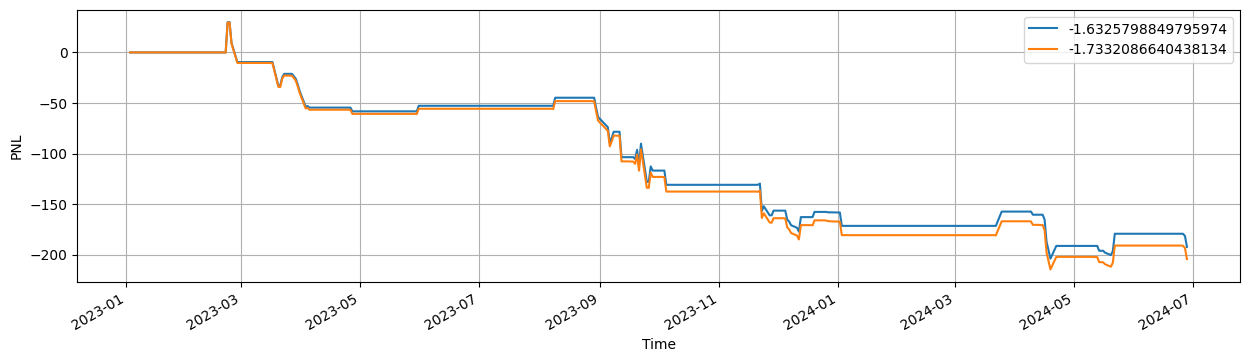

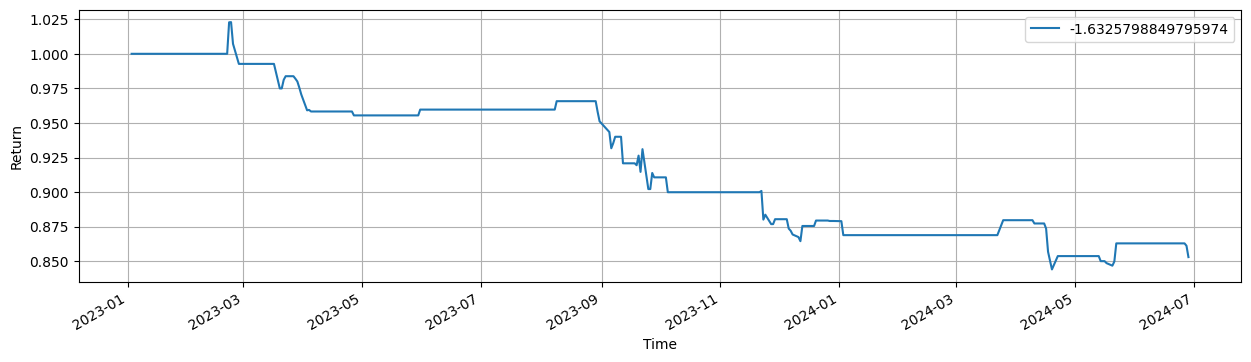

In [9]:
backtesting = F.BacktestInformation(data_VN30_position['time'], data_VN30_position['position'], data_VN30_position['close'])
backtest = backtesting.Plot_PNL()

Margin: -6.355603476799622
MDD: (44.54785907859104, 0.03470756909015133)

   Total trading quantity: 31
         Profit per trade: -1.4561290322580898
             Total Profit: -45.1
         Profit after fee: -58.1
 Trading quantity per day: 0.08401084010840108
 Profit per day after fee: -0.15745257452574526
                   Return: -0.030427517926071627
          Profit per year: -39.054327808471456
                  HitRate: 0.5161290322580645
          HitRate per day: 0.06521739130434782


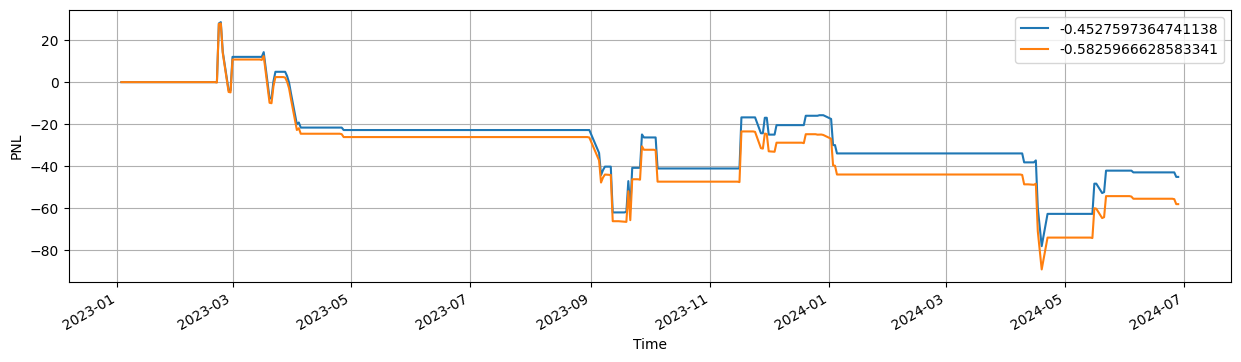

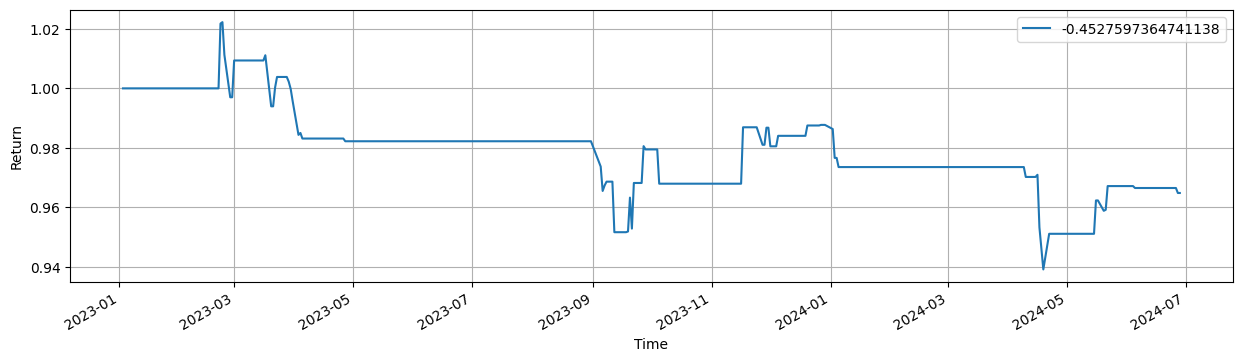

In [10]:
backtesting = F.BacktestInformation(data_VNI_position['time'], data_VNI_position['position'], data_VNI_position['close'])
backtest = backtesting.Plot_PNL()

In [11]:
%%capture
data_VNI_position = test(data_VNI, 15)
data_VN30_position = test(data_VN30, 15)

Margin: -7.39302943564788
MDD: (128.8862872628724, 0.0966272723791074)

   Total trading quantity: 59
         Profit per trade: -1.7161016949152503
             Total Profit: -101.2
         Profit after fee: -126.9
 Trading quantity per day: 0.15989159891598917
 Profit per day after fee: -0.34390243902439027
                   Return: -0.06395104769829868
          Profit per year: -85.3011049723757
                  HitRate: 0.3728813559322034
          HitRate per day: 0.10054347826086957


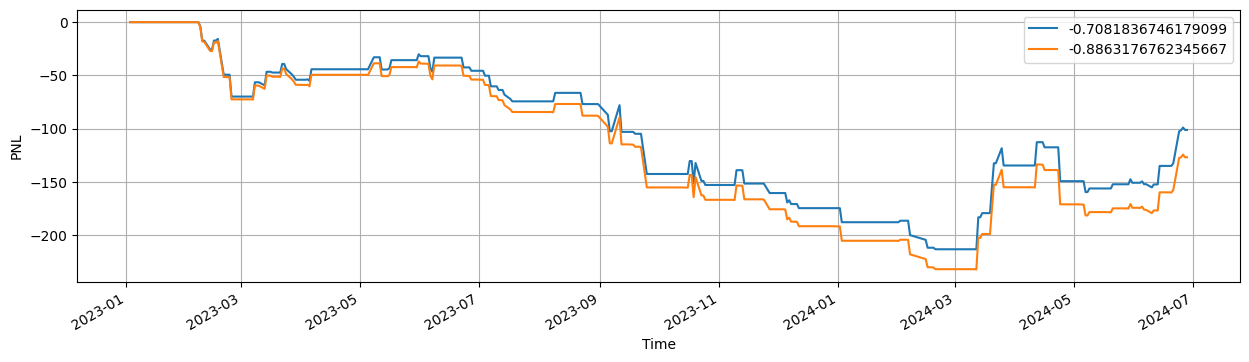

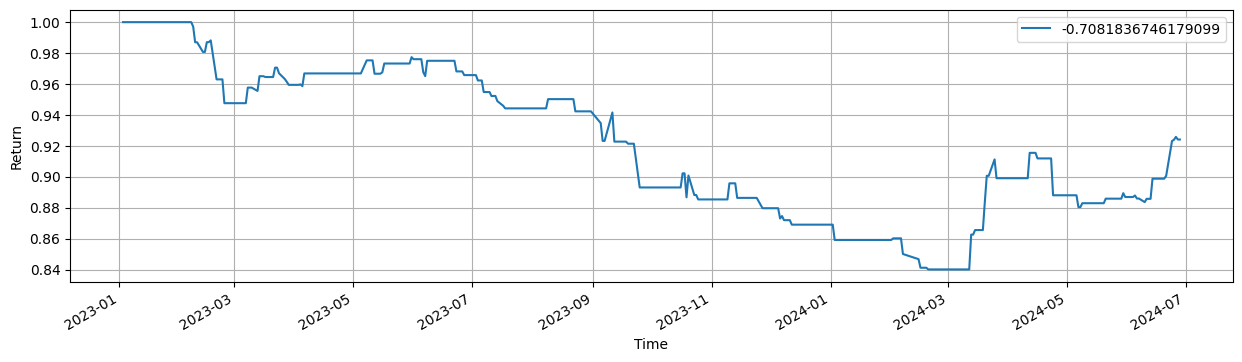

In [12]:
backtesting = F.BacktestInformation(data_VN30_position['time'], data_VN30_position['position'], data_VN30_position['close'])
backtest = backtesting.Plot_PNL()

Margin: -3.056900489158552
MDD: (146.27113821138317, 0.1136015922982519)

   Total trading quantity: 56
         Profit per trade: -0.7033928571428915
             Total Profit: -39.4
         Profit after fee: -63.7
 Trading quantity per day: 0.15176151761517614
 Profit per day after fee: -0.1726287262872629
                   Return: -0.03325509899837224
          Profit per year: -42.81860036832413
                  HitRate: 0.39285714285714285
          HitRate per day: 0.08695652173913043


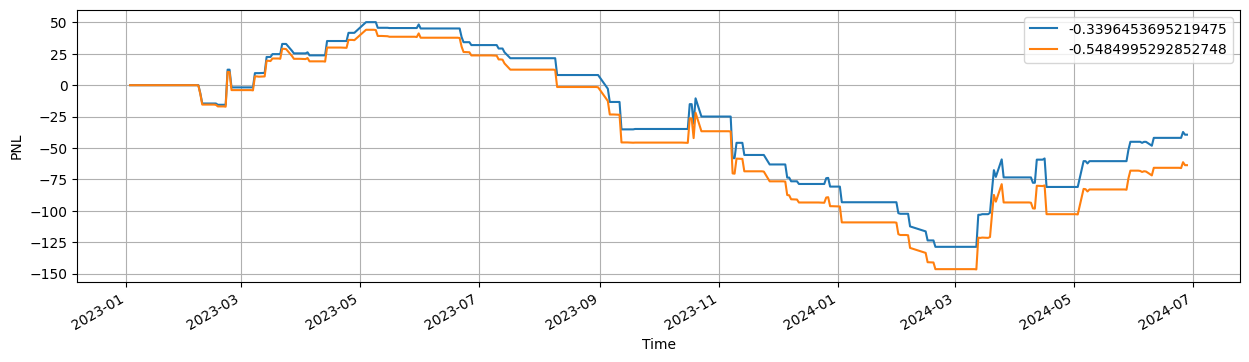

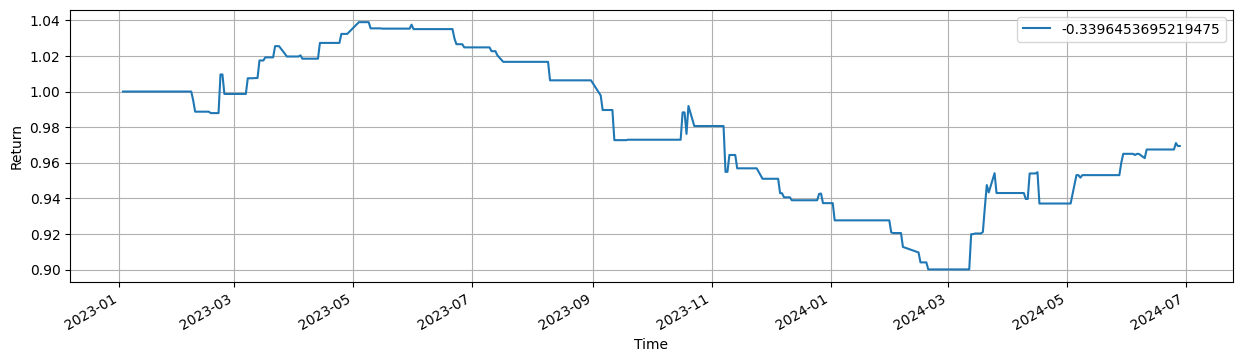

In [13]:
backtesting = F.BacktestInformation(data_VNI_position['time'], data_VNI_position['position'], data_VNI_position['close'])
backtest = backtesting.Plot_PNL()

In [14]:
%%capture
data_VNI_position = test(data_VNI, 10)
data_VN30_position = test(data_VN30, 10)

Margin: 6.692130967314629
MDD: (98.21452574525786, 0.07440888967237494)

   Total trading quantity: 76
         Profit per trade: 1.5618421052631764
             Total Profit: 118.7
         Profit after fee: 84.9
 Trading quantity per day: 0.20596205962059622
 Profit per day after fee: 0.23008130081300815
                   Return: 0.0432364297905803
          Profit per year: 57.069060773480665
                  HitRate: 0.5131578947368421
          HitRate per day: 0.14673913043478262


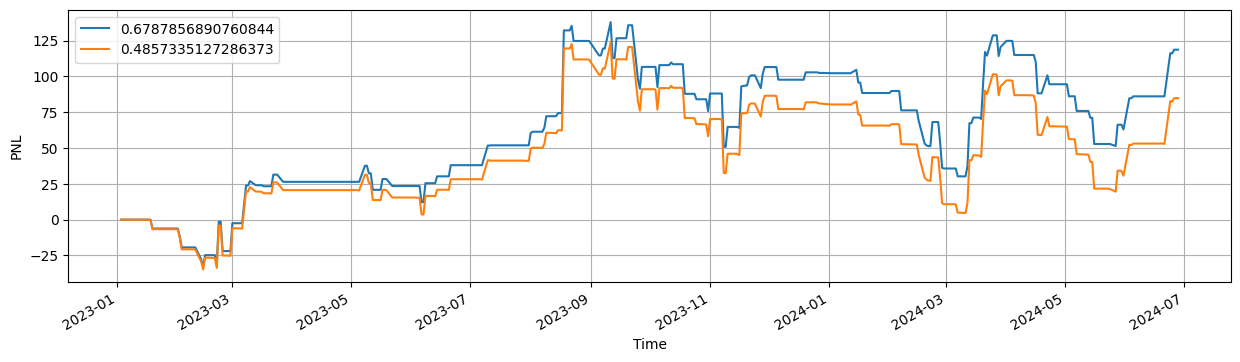

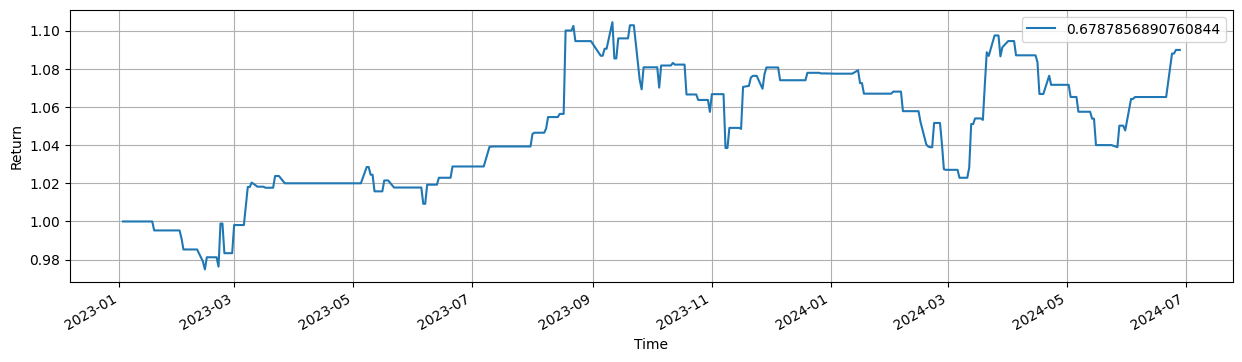

In [15]:
backtesting = F.BacktestInformation(data_VN30_position['time'], data_VN30_position['position'], data_VN30_position['close'])
backtest = backtesting.Plot_PNL()

Margin: 5.219636241449491
MDD: (93.46972899729097, 0.07181637405574369)

   Total trading quantity: 77
         Profit per trade: 1.2164935064934927
             Total Profit: 93.7
         Profit after fee: 59.3
 Trading quantity per day: 0.2086720867208672
 Profit per day after fee: 0.16070460704607045
                   Return: 0.03062670101860577
          Profit per year: 39.860957642725594
                  HitRate: 0.5064935064935064
          HitRate per day: 0.12771739130434784


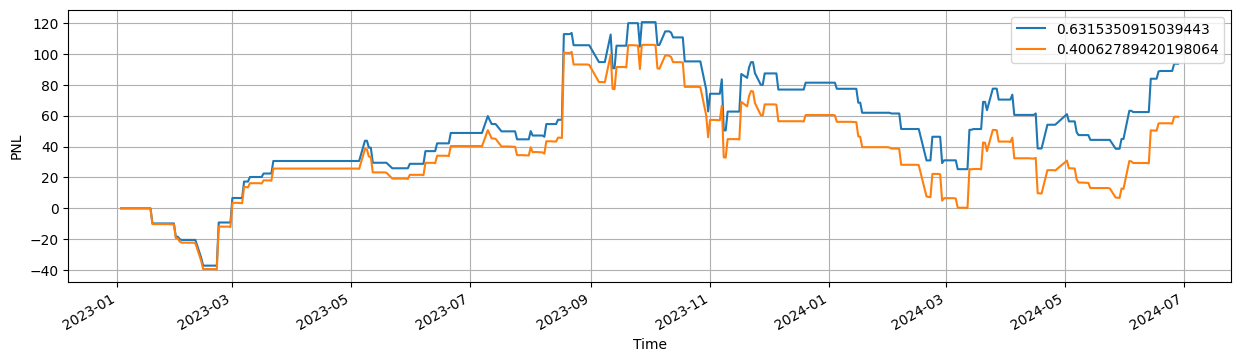

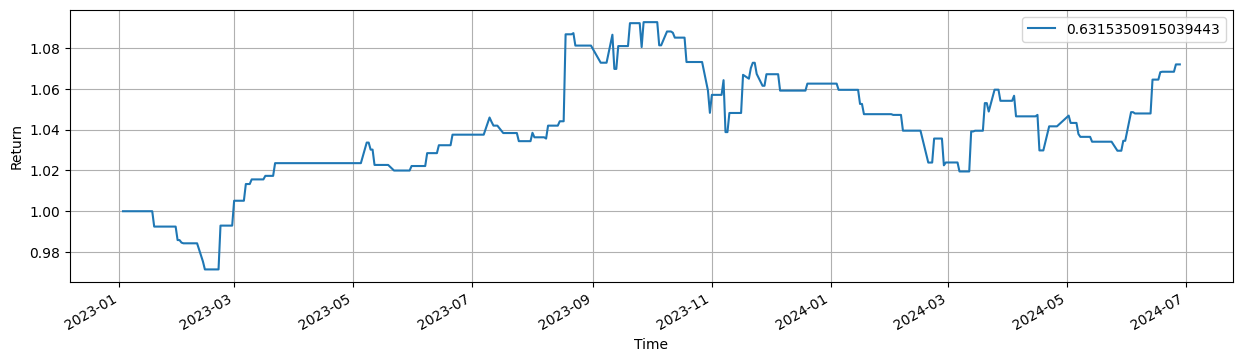

In [16]:
backtesting = F.BacktestInformation(data_VNI_position['time'], data_VNI_position['position'], data_VNI_position['close'])
backtest = backtesting.Plot_PNL()

In [17]:
%%capture
data_VNI_position = test(data_VNI, 7)
data_VN30_position = test(data_VN30, 7)

Margin: 3.527270256838657
MDD: (79.07842818428226, 0.059285847872161235)

   Total trading quantity: 88
         Profit per trade: 0.8236363636363742
             Total Profit: 72.5
         Profit after fee: 32.7
 Trading quantity per day: 0.23848238482384823
 Profit per day after fee: 0.0886178861788618
                   Return: 0.016479111581831102
          Profit per year: 21.980662983425415
                  HitRate: 0.4659090909090909
          HitRate per day: 0.13858695652173914


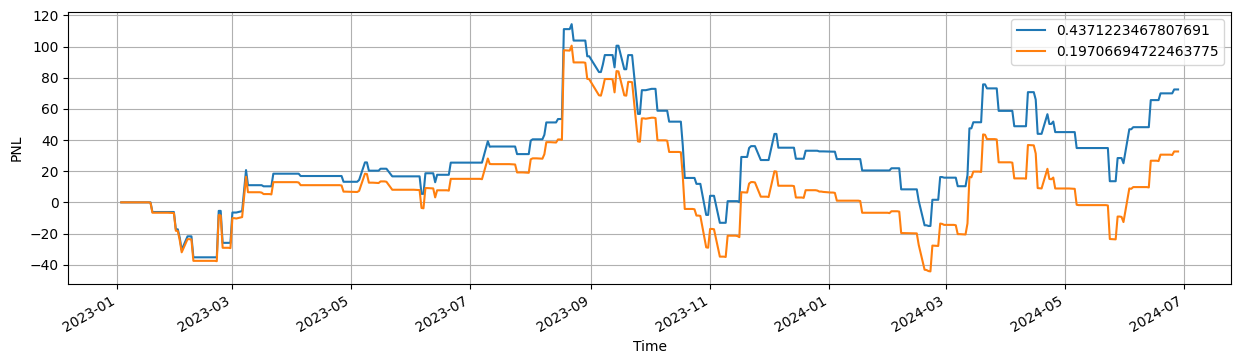

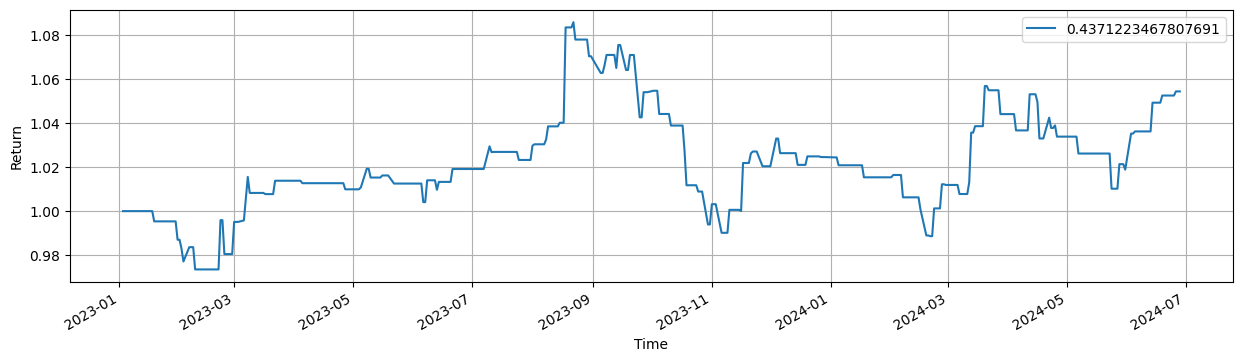

In [18]:
backtesting = F.BacktestInformation(data_VN30_position['time'], data_VN30_position['position'], data_VN30_position['close'])
backtest = backtesting.Plot_PNL()

Margin: 3.3297408930052894
MDD: (57.725365853658545, 0.044352610316984536)

   Total trading quantity: 84
         Profit per trade: 0.7755952380952283
             Total Profit: 65.1
         Profit after fee: 27.3
 Trading quantity per day: 0.22764227642276422
 Profit per day after fee: 0.07398373983739838
                   Return: 0.014099644819695407
          Profit per year: 18.35082872928177
                  HitRate: 0.4880952380952381
          HitRate per day: 0.12771739130434784


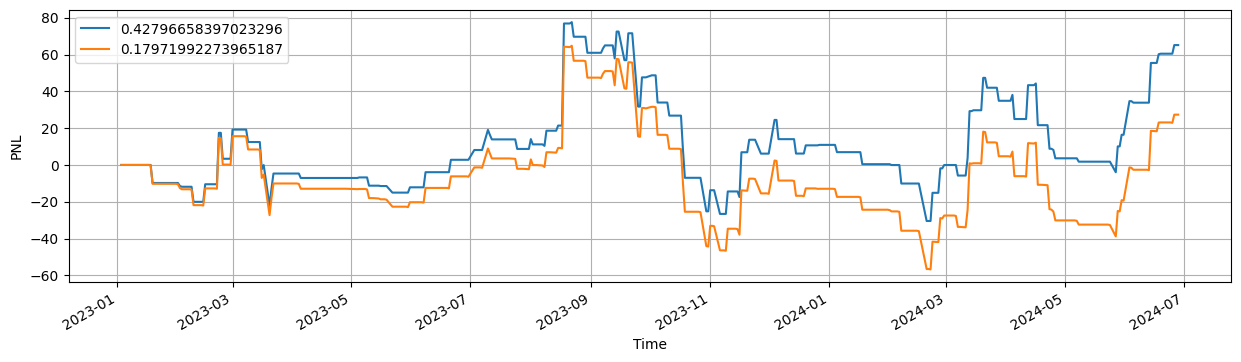

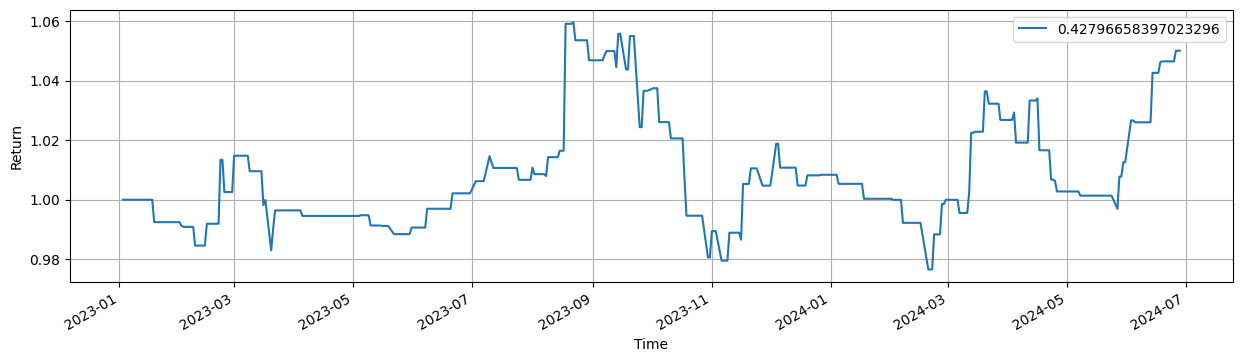

In [19]:
backtesting = F.BacktestInformation(data_VNI_position['time'], data_VNI_position['position'], data_VNI_position['close'])
backtest = backtesting.Plot_PNL()